## Real Stock Portfolio Optimization (Fractional VQE Client)

This notebook is an **example client** of the fractional VQE workflow, using **real market data**.

### Pipeline

1. Download adjusted prices for a set of tickers (Yahoo Finance via `yfinance`).
2. Compute annualized expected returns \(\mu\) and covariance \(\Sigma\).
3. Run a simplex-parameterized “fractional VQE” loop:

\[
\min_{w \in \Delta}\; -\mu^\top w + \lambda\, w^\top \Sigma w,
\qquad
\Delta=\{w \ge 0,\ \sum_i w_i=1\}.
\]

We map circuit expectations \(z_i=\langle Z_i\rangle\) to scores \(s_i=(1-z_i)/2\) and normalize
\(w_i=s_i/\sum_j s_j\), so weights are valid **by construction** (no penalty tuning).

### Notes

- Results depend on the data window, return convention (log vs simple), and covariance estimator.
- This example uses exact expectations (`shots=None`) for stable training; evaluate with finite shots for a deployment-like regime.

In [1]:
import os
from dataclasses import dataclass

import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np

from vqe_portfolio.data import get_stock_data

# Reproducibility
SEED = 0
np.random.seed(SEED)

# Write images into the repo's notebooks/images folder (consistent with other notebooks)
OUTDIR = os.path.join("..", "images")
os.makedirs(OUTDIR, exist_ok=True)

In [2]:
# ---- Data configuration ----
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN"]
start = "2023-01-01"
end = "2024-01-01"

# Estimation options (keep explicit for reproducibility)
use_log = True
shrink = "lw"      # None or "lw"
scale = "none"     # "none", "trace", "max" (leave "none" for natural units)

mu_s, Sigma_df, prices = get_stock_data(
    tickers,
    start=start,
    end=end,
    auto_adjust=True,
    use_log=use_log,
    shrink=shrink,
    scale=scale,
)

# Convert to PennyLane numpy arrays (ordered by tickers)
mu = np.array(mu_s.loc[tickers].values, requires_grad=False)
Sigma = np.array(Sigma_df.loc[tickers, tickers].values, requires_grad=False)

# Defensive symmetrization and sanity checks
Sigma = 0.5 * (Sigma + Sigma.T)
n_assets = len(tickers)

print("Tickers:", tickers)
print("Annualized mu:")
for t, m in zip(tickers, mu):
    print(f"  {t}: {float(m): .6f}")
print("\nSigma (annualized) shape:", Sigma.shape)
print("Prices rows:", prices.shape[0])

Tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
Annualized mu:
  AAPL:  0.426791
  MSFT:  0.448947
  GOOGL:  0.438990
  AMZN:  0.557949

Sigma (annualized) shape: (4, 4)
Prices rows: 259


In [3]:
# ---- Optimization configuration ----
@dataclass(frozen=True)
class VQEConfig:
    steps: int = 100
    stepsize: float = 0.25
    log_every: int = 10
    shots: int | None = None  # None -> exact expectations


cfg = VQEConfig()

# Risk aversion λ
lam = 0.5

In [4]:
# ---- Quantum model: simplex-parameterized weights ----
dev = qml.device("default.qubit", wires=n_assets, shots=cfg.shots)


def ansatz(thetas: np.ndarray) -> None:
    """Baseline ansatz: single RY layer (independent per asset)."""
    for i in range(n_assets):
        qml.RY(thetas[i], wires=i)


@qml.qnode(dev, interface="autograd")
def expvals_z(thetas: np.ndarray):
    ansatz(thetas)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_assets)]


def angles_to_weights(thetas: np.ndarray) -> np.ndarray:
    z = qml.math.stack(expvals_z(thetas))
    s = (1.0 - z) * 0.5
    s_sum = qml.math.sum(s)
    return s / (s_sum + 1e-12)


def portfolio_return(w):
    return qml.math.dot(mu, w)


def portfolio_variance(w):
    return qml.math.dot(w, qml.math.dot(Sigma, w))


def objective(thetas: np.ndarray):
    w = angles_to_weights(thetas)
    return -(portfolio_return(w)) + lam * portfolio_variance(w)

In [5]:
# ---- Optimize ----
thetas = np.array(np.random.uniform(0, np.pi, n_assets), requires_grad=True)
opt = qml.AdamOptimizer(stepsize=cfg.stepsize)

history_steps = []
history_cost = []

for t in range(cfg.steps):
    thetas, cost = opt.step_and_cost(objective, thetas)

    if (t + 1) % cfg.log_every == 0:
        w = angles_to_weights(thetas)
        history_steps.append(t + 1)
        history_cost.append(float(cost))
        print(
            f"step {t+1:03d}  cost={float(cost):.6f}  sum(w)={float(np.sum(w)):.6f}"
        )

w_opt = angles_to_weights(thetas)
w_opt = w_opt / (np.sum(w_opt) + 1e-12)

step 010  cost=-0.498571  sum(w)=1.000000
step 020  cost=-0.501564  sum(w)=1.000000
step 030  cost=-0.504113  sum(w)=1.000000
step 040  cost=-0.505663  sum(w)=1.000000
step 050  cost=-0.506216  sum(w)=1.000000
step 060  cost=-0.506418  sum(w)=1.000000
step 070  cost=-0.506508  sum(w)=1.000000
step 080  cost=-0.506525  sum(w)=1.000000
step 090  cost=-0.506528  sum(w)=1.000000
step 100  cost=-0.506529  sum(w)=1.000000


In [6]:
# ---- Report ----
print("\nOptimized weights:")
for t, w in zip(tickers, w_opt):
    print(f"{t}: {float(w)*100:.2f}%")

print(f"\nPortfolio return: {float(portfolio_return(w_opt)):.6f}")
print(f"Portfolio risk  : {float(np.sqrt(portfolio_variance(w_opt))):.6f}")


Optimized weights:
AAPL: 0.00%
MSFT: 0.00%
GOOGL: 0.00%
AMZN: 100.00%

Portfolio return: 0.557947
Portfolio risk  : 0.320679


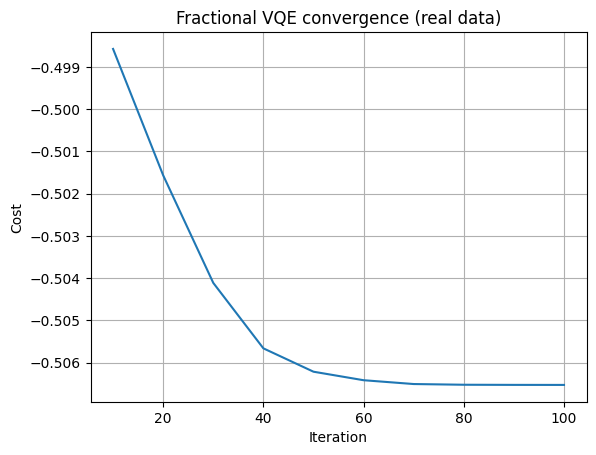

In [7]:
# ---- Convergence plot ----
plt.figure()
plt.plot(history_steps, history_cost)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Fractional VQE convergence (real data)")
plt.grid(True)
plt.savefig(os.path.join(OUTDIR, "Fractional_Example_Convergence.png"), dpi=300, bbox_inches="tight")
plt.show()

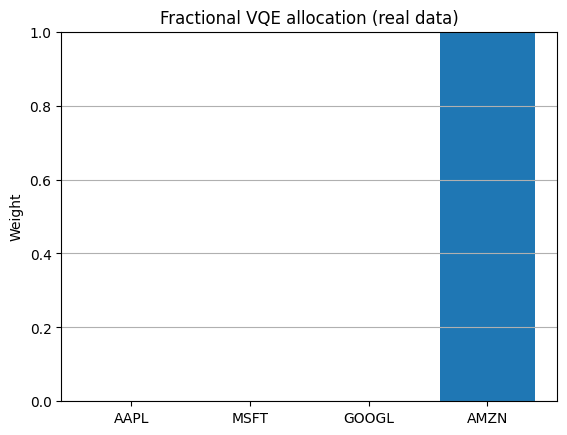

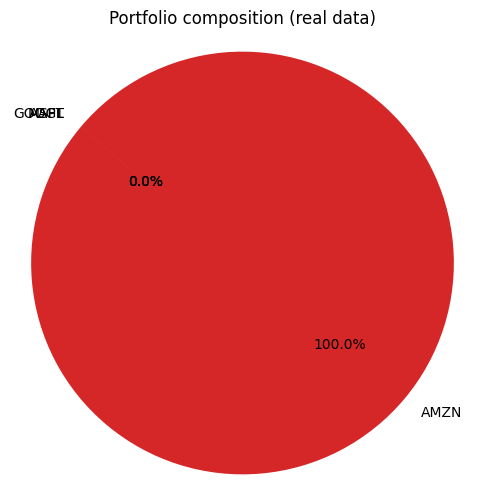

In [8]:
# ---- Allocation plots ----
plt.figure()
plt.bar(tickers, w_opt)
plt.ylabel("Weight")
plt.ylim(0, 1)
plt.title("Fractional VQE allocation (real data)")
plt.grid(axis="y")
plt.savefig(os.path.join(OUTDIR, "Fractional_Example_Probabilities.png"), dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(6, 6))
plt.pie(w_opt, labels=tickers, autopct="%1.1f%%", startangle=140)
plt.title("Portfolio composition (real data)")
plt.axis("equal")
plt.savefig(os.path.join(OUTDIR, "Fractional_Example_Pie.png"), dpi=300, bbox_inches="tight")
plt.show()